In [1]:
from Binaries import *

def do_t3_simulation(self, dataset : str, n_points : int = 1e5, **kwargs) -> None :

    import seaborn as sns

    if isinstance(n_points, float): n_points = int(n_points)

    if isinstance(self, NNClassifier):
        root_path = f"/cr/data01/filip/models/{self.name}/model_{self.epochs}/ROC_curve/{dataset}/"
    else:
        root_path = f"/cr/data01/filip/models/{self.name}/ROC_curve/{dataset}/"

    colormap = plt.colormaps["plasma"]
    fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios = [kwargs.get("x1", 1), kwargs.get("x2", 1)])

    dx = 100
    theta = kwargs.get("theta", 38)
    tolerance = kwargs.get("tolerance", 4)

    # set up plot
    ax1.text( 635, -55, "T3 detected", fontsize = 22)
    ax1.text(1395 + dx, 775, "T3 missed", fontsize = 22)
    symmetry_line = lambda x : 1500 - x
    X = np.linspace(700, 1550, 100)
    ax1.scatter([0, 1500, 750], [0, 0, 750], s = 100, c = "k")
    ax1.scatter([1500 + dx, 750 + dx, 2250 + dx], [0, 750, 750], s = 100, c = "k")
    ax1.plot(X + dx/2, symmetry_line(X), ls = "solid", c = "k", zorder = 0, lw = 2)
    ax1.add_patch(Polygon([[0,0], [1500, 0], [750, 750]], closed = True, color = "green", alpha = 0.1, lw = 0))
    ax1.add_patch(Polygon([[750 + dx, 750], [1500 + dx, 0], [2250 + dx, 750]], closed = True, color = "red", alpha = 0.1, lw = 0))

    # create shower cores in target area
    theta_bins = [0, 26, 38, 49, 60, 90]
    ys = np.random.uniform(0, 750, n_points)
    xs = np.random.uniform(0, 1500, n_points) + ys
    reflect = [ ys[i] > symmetry_line(xs[i]) for i in range(len(xs))]
    xs[reflect] = -xs[reflect] + 2250
    ys[reflect] = -ys[reflect] + 750

    energy_hits, energy_miss = [], []

    energy_bins = [10**16, 10**16.5, 10**17, 10**17.5, 10**18, 10**18.5, 10**19, 10**19.5]      # uniform in log(E)
    theta_bins =  [0.0000, 33.5600, 44.4200, 51.3200, 56.2500, 65.3700]                         # pseudo-uniform in sec(θ)

    start_time = perf_counter_ns()

    # do the T3 simulation
    t3_hits = [[0 for t in range(len(theta_bins) - 1)] for e in range(len(energy_bins) - 1)]
    t3_misses = [[0 for t in range(len(theta_bins) - 1)] for e in range(len(energy_bins) - 1)]
    x_container = [[[] for t in range(len(theta_bins) - 1)] for e in range(len(energy_bins) - 1)]
    y_container = [[[] for t in range(len(theta_bins) - 1)] for e in range(len(energy_bins) - 1)]
    container_hits = [[] for t in range(len(theta_bins) - 1)]
    container_miss = [[] for t in range(len(theta_bins) - 1)]
    stations = [[0, 0, 0], [1500, 0, 0], [750, 750, 0]]

    for step_count, (x, y) in enumerate(zip(xs, ys)):

        progress_bar(step_count, n_points, start_time)

        random_phi = np.random.uniform(0, 360)
        random_energy = 10**(np.random.uniform(low = 16, high = 19.5))
        random_zenith = np.random.uniform(low = 0, high = 65)
        eb = np.digitize(random_energy, energy_bins) - 1
        tb = np.digitize(random_zenith, theta_bins) - 1

        fit_function, _ = get_fit_function(root_path, eb, tb)

        sp_distances = []
        
        for station in stations:

            core_position = np.array([x, y, 0])
            core_origin = np.sin(random_zenith) * np.array([np.cos(random_phi), np.sin(random_phi), 1/np.tan(random_zenith)]) + core_position

            shower_ax1is = core_position - core_origin
            dot_norm = np.dot(shower_ax1is, shower_ax1is)
            perpendicular_norm = np.dot(station - core_origin, shower_ax1is) / dot_norm
            sp_distances.append( np.linalg.norm(perpendicular_norm * shower_ax1is + (core_origin - station)))

        # #  In case of paranoia regarding distance calculation break comment
        # ax1.add_patch(plt.Circle((0, 0), sp_distances[0], color='b', fill=False))
        # ax1.add_patch(plt.Circle((1500, 0), sp_distances[1], color='b', fill=False))
        # ax1.add_patch(plt.Circle((750, 750), sp_distances[2], color='b', fill=False))

        trigger_probabilities = [fit_function(distance) for distance in sp_distances]
        dice_roll = np.random.uniform(0, 1, 3)

        if np.all(dice_roll < trigger_probabilities):
            t3_hits[eb][tb] += 1
            container_hits[tb].append(random_energy)

        else:
            x, y = 2250 - x + dx, 750 - y
            t3_misses[eb][tb] += 1
            container_miss[tb].append(random_energy)

            if theta - tolerance/2 <= random_zenith < theta + tolerance/2:
                energy_miss.append(random_energy)

        x_container[eb][tb].append(x)
        y_container[eb][tb].append(y)

    size_bins = [30, 50, 70, 90, 110, 160, 200]
    e_labels = [r"$16$", r"$16.5$", r"$17$", r"$17.5$", r"$18$", r"$18.5$", r"$19$", r"$19.5$"]

    for e, (x_energy, y_energy) in enumerate(zip(x_container, y_container)):
        for t, (x, y) in enumerate(zip(x_energy, y_energy)):

            c = colormap(t / len(x_energy))
            s = size_bins[e]

            ax1.scatter(x[::kwargs.get("step", 50)], y[::kwargs.get("step", 50)], color = c, s = s, marker = "x")

    for e, bin in enumerate(size_bins):
        ax1.scatter([],[], c = "k", s = bin, label = e_labels[e] + r" $\leq$ log$_{10}$($E$ / $\mathrm{eV}$) $<$ " + e_labels[e + 1], marker = "x")

    ax1.set_aspect('equal')
    ax1.legend()
    ax1.set_xlabel("Easting / m")
    ax1.set_ylabel("Northing / m")

    norm = BoundaryNorm(theta_bins, colormap.N)
    axis2 = fig.add_axes([0.68, 0.3, 0.01, 0.385])

    cbar = ColorbarBase(axis2, cmap=colormap, norm=norm, label = r"sec$(\theta)$ - 1")
    cbar.set_ticks(theta_bins)
    cbar.set_ticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.4"])

    theta_bins =  [0.0000, 33.5600, 44.4200, 51.3200, 56.2500, 65.3700]                         # pseudo-uniform in sec(θ)

    e_labels = EventGenerator.libraries.keys()
    t_labels = ["0_34", "34_44", "44_51", "51_56", "56_65"]

    t3_hits = np.array(t3_hits)
    t3_misses = np.array(t3_misses)

    sns.heatmap(t3_hits / (t3_hits + t3_misses), annot = True, fmt = ".1f", ax = ax2, cbar = False, cmap = "plasma")
    ax2.set_xticks(ticks = 0.5 + np.arange(0, 5, 1), labels = t_labels)
    ax2.set_yticks(ticks = 0.5 + np.arange(0, 7, 1), labels = e_labels)
    ax2.set_xlabel("Zenith range")
    ax2.set_ylabel("Energy range")

    ax2.set_aspect("equal")

    plt.subplots_adjust(wspace = 0.28)

    fig = plt.figure()

    e_bins_efficiency = np.geomspace(10**16, 10**19.5, kwargs.get("e_bins", len(energy_bins) - 1))

    for t, (energy_hits, energy_miss) in enumerate(zip(container_hits, container_miss)):
        n_hit, bins = np.histogram(energy_hits, bins = e_bins_efficiency)
        n_miss, bins = np.histogram(energy_miss, bins = e_bins_efficiency)
        eff_err = 1/(n_hit + n_miss)**2 * np.sqrt( n_hit**3 + n_miss**3 - 2 * np.sqrt((n_hit * n_miss)**3) )
        eff = n_hit / (n_miss + n_hit)

        upper = np.clip(eff + eff_err, 0, 1)
        lower = np.clip(eff - eff_err, 0, 1)

        plt.errorbar(0.5 * (bins[1:] + bins[:-1]), eff, yerr = [eff - lower, upper - eff], fmt = "-o", c = colormap(t / (len(theta_bins) - 1)))

    plt.ylabel("T3 Trigger efficiency")
    plt.xlabel("Primary energy / $\mathrm{eV}$")
    plt.xscale("log")

    norm = BoundaryNorm(theta_bins, colormap.N)
    ax2 = fig.add_axes([0.91, 0.1, 0.01, 0.8])

    cbar = ColorbarBase(ax2, cmap=colormap, norm=norm, label = r"sec$(\theta)$ - 1")
    cbar.set_ticks(theta_bins)
    cbar.set_ticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.4"])


/tmp/ipykernel_1646504/2014672828.py:154: RuntimeWarning: invalid value encountered in sqrt
  eff_err = 1/(n_hit + n_miss)**2 * np.sqrt( n_hit**3 + n_miss**3 - 2 * np.sqrt((n_hit * n_miss)**3) )


NameError: name 'ax12' is not defined

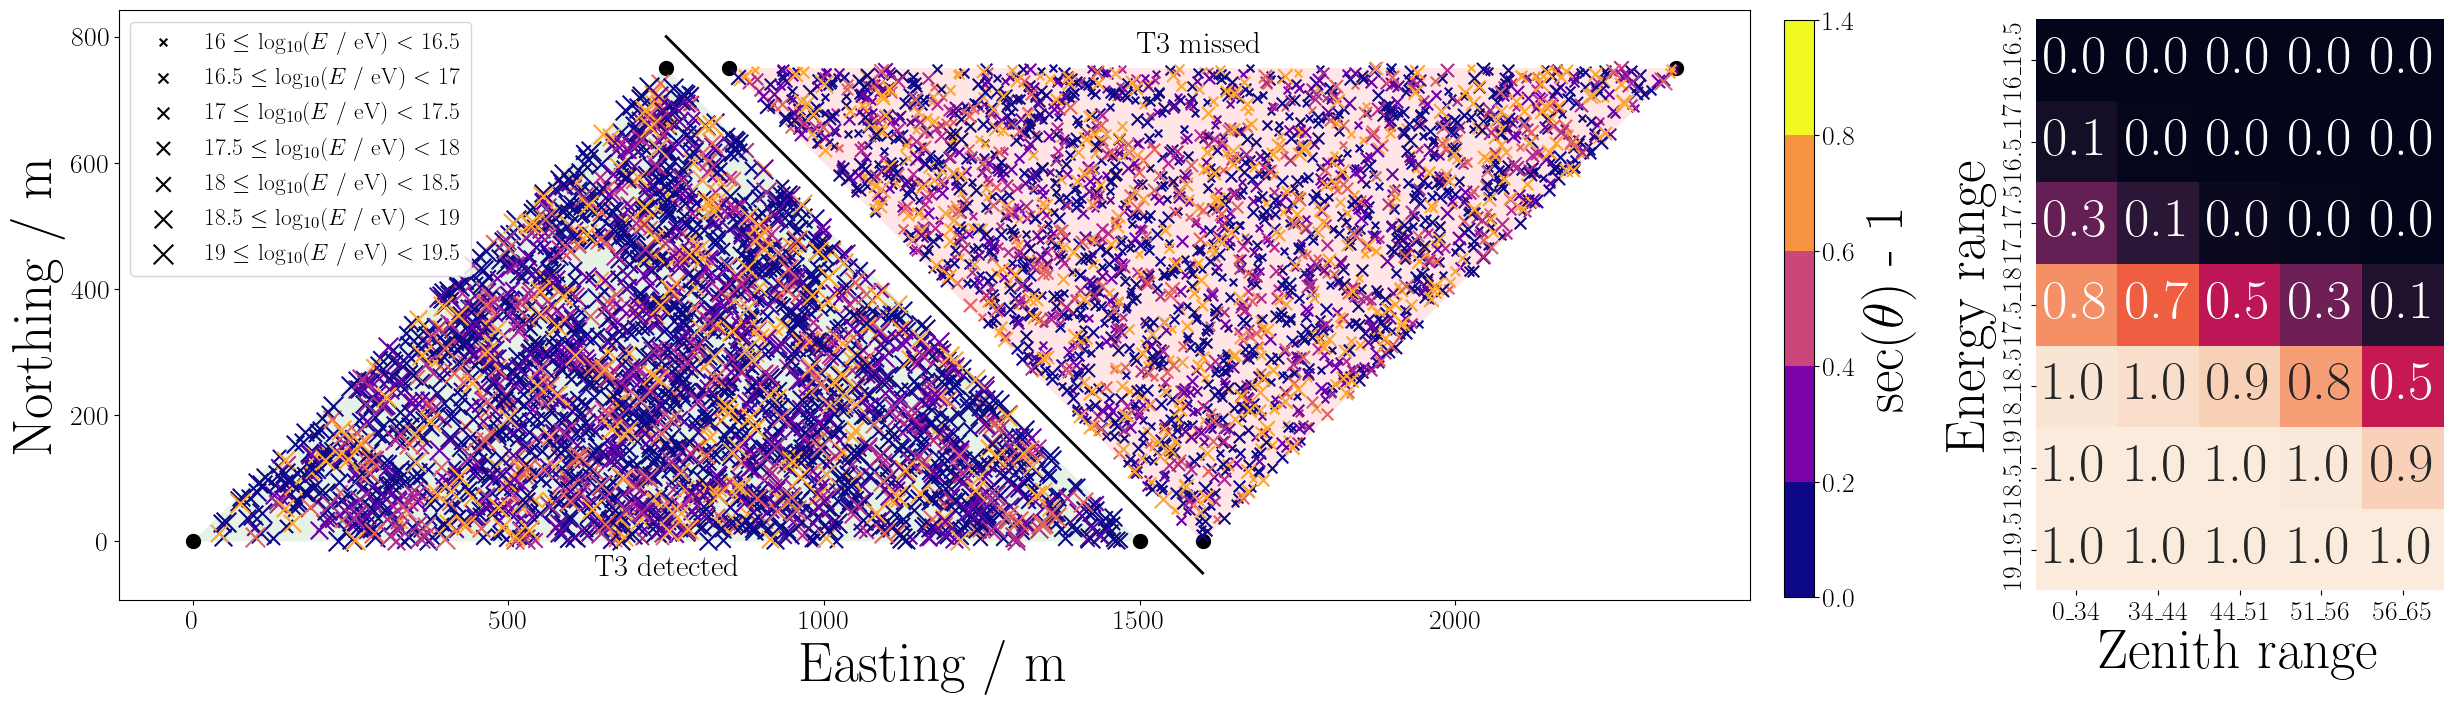

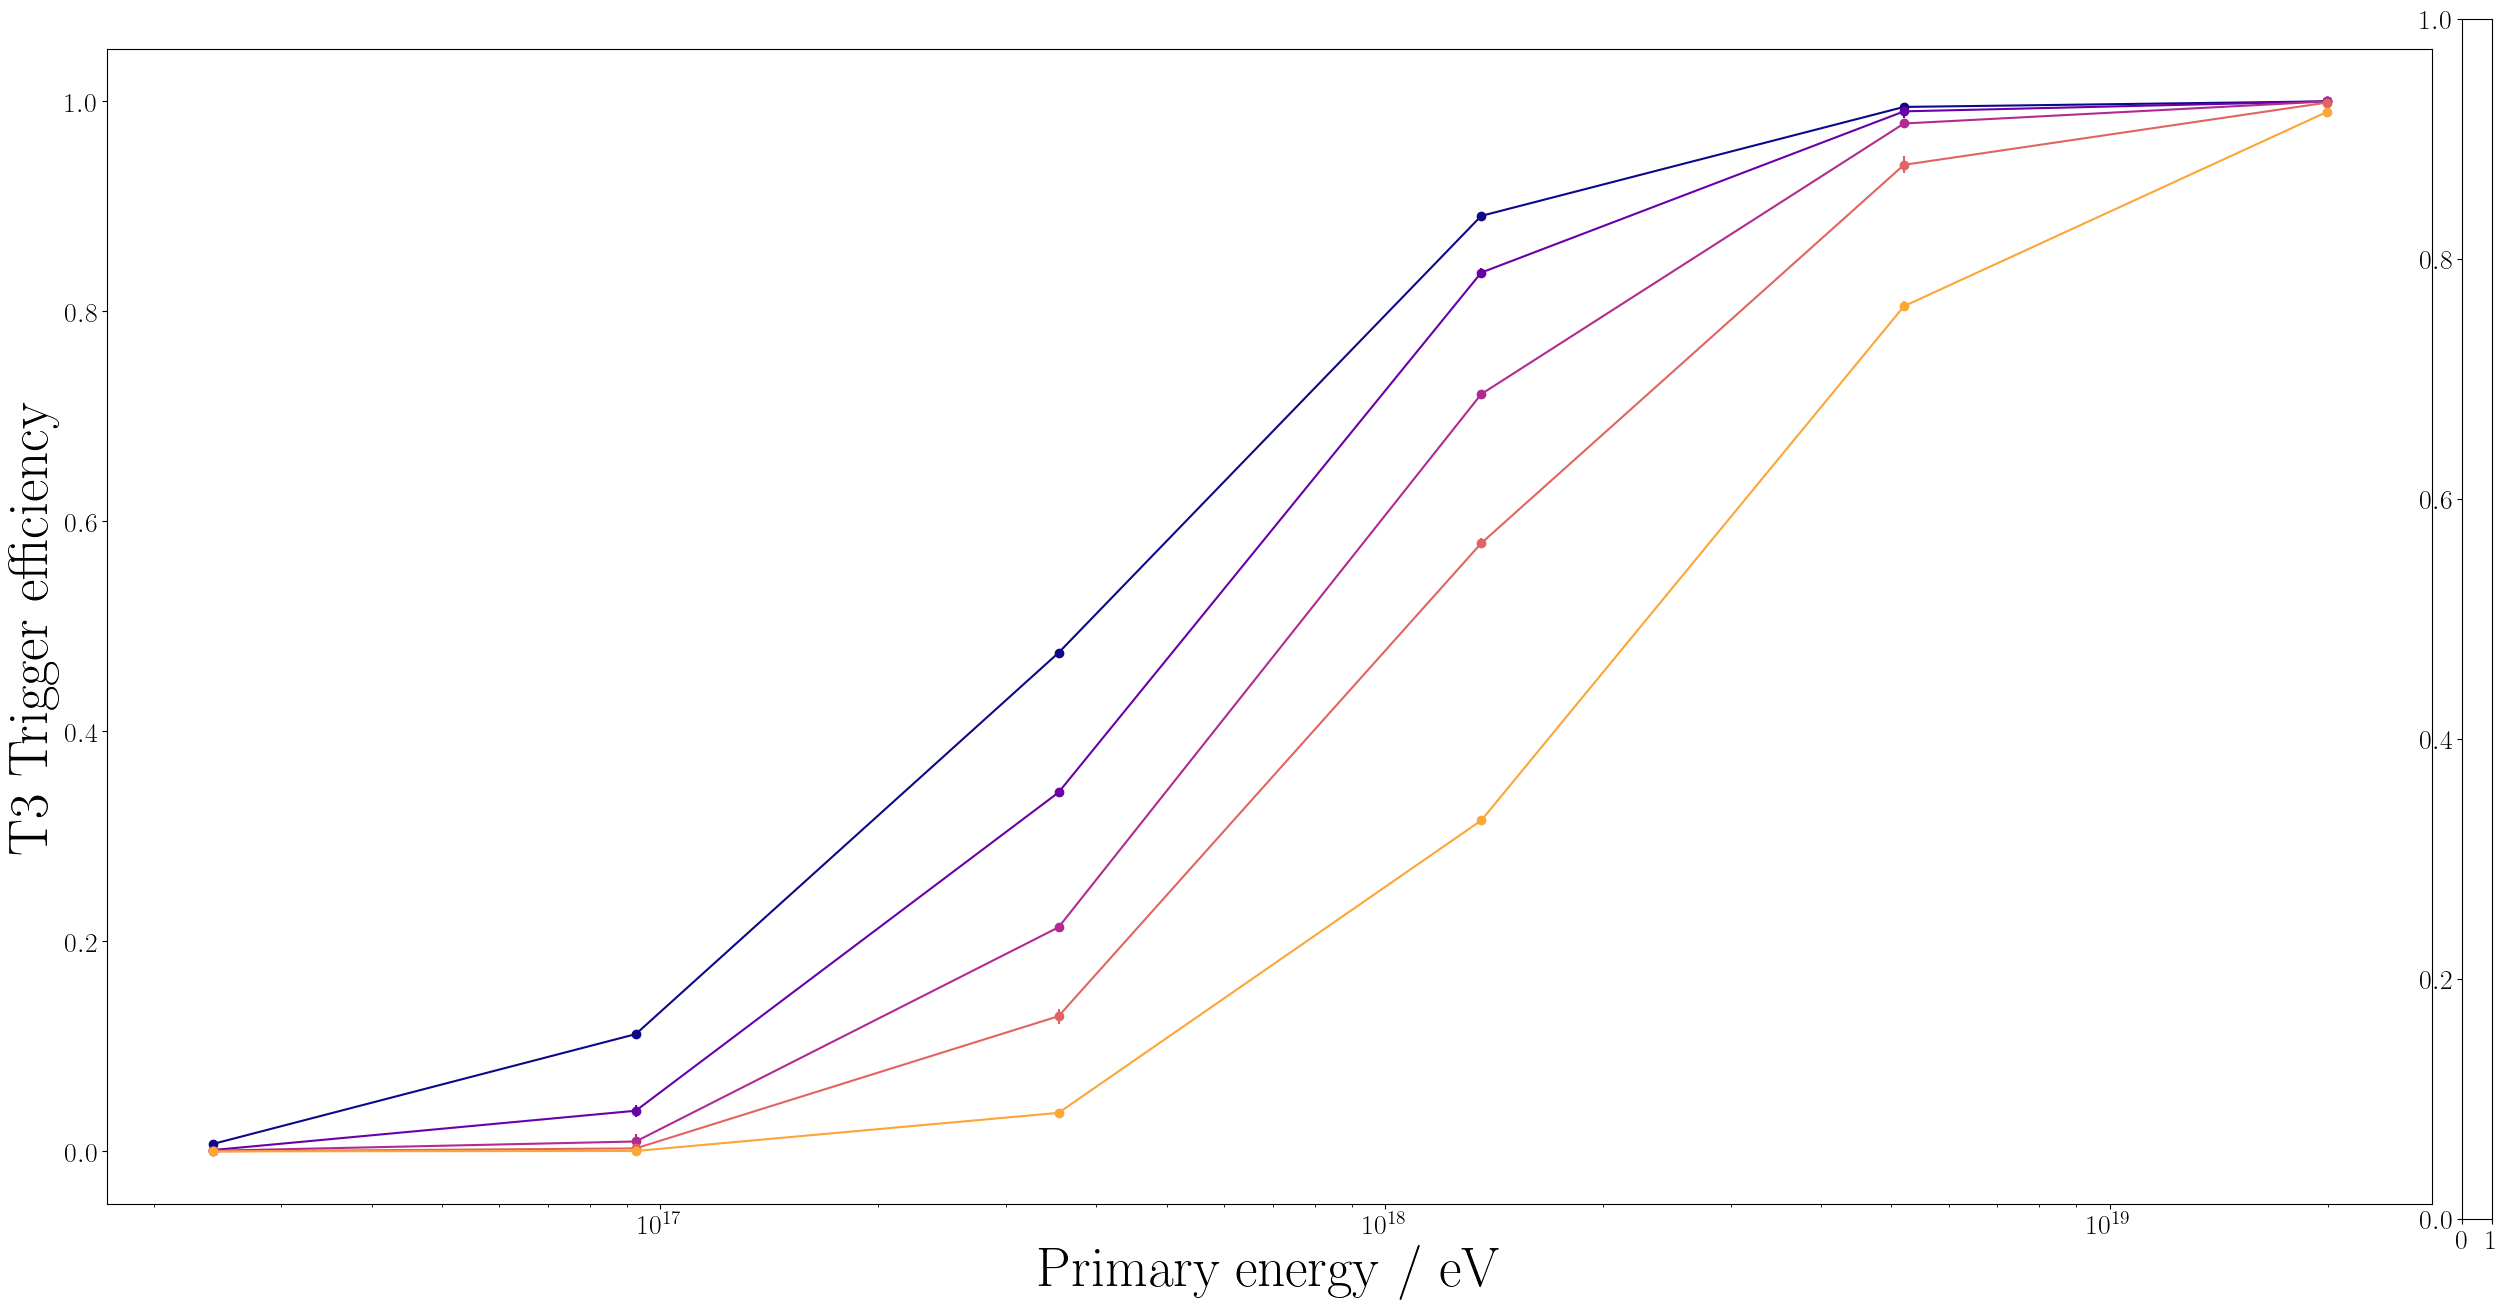

In [2]:
from Binaries import *

plt.rcParams["axes.labelsize"] = 40
plt.rcParams["legend.fontsize"] = 17
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20

Trigger = HardwareClassifier()
do_t3_simulation(Trigger, "final_all_triggers", 1e3, step = 180, x1 = 4, x2 = 1)